<a href="https://colab.research.google.com/github/DSoysal/image_generation_with_evolutionary_algorithm/blob/main/even_better_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

#import multiprocessing as mp
#from joblib import Parallel, delayed

### Class and function definitions

helper functions

In [ ]:
def tournament(contestants, tm_size):
      tm_size = tm_size
      best = random.choice(contestants)
      while tm_size != 0:
        random_contestant = random.choice(contestants)
        if random_contestant.fitness > best.fitness:
          best = random_contestant
        tm_size -= 1
      return best

def draw_individual(individual, chromosome_length, generation_number):
      img = cv2.imread(source_img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      individual.chromosome.sort(key=lambda x: x[2], reverse=True)


      drawed_length = (generation_number // 1000) * 5

      image = np.ones(np.array(img.shape), dtype = np.uint8)
      for j in range(drawed_length): # For each gene
            overlay = image.copy()
            gene = individual.chromosome[j]
            x, y, radius, R, G, B, alpha = gene

            # Draw individual
            cv2.circle(overlay, (x, y), radius, (R, G, B), -1)
            image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

      return image

def mean_fitness(individual_list):
      sum = 0
      for ind in individual_list:
        sum += ind.fitness
      return sum/len(individual_list)

def list_fitness(individual_list):
      for ind in individual_list:
        print(ind.fitness)

################### JUST USE THIS IN PLACE OF calculate_individual_fitness() ##########################
def calculate_inidividual_fitness_with_gene_locking(individual, source_img, last_img, generation_number):
      chromosome_length = len(individual.chromosome)
      image = last_img.copy()
      individual.chromosome.sort(key=lambda x: x[2], reverse=True)

      active_length = (generation_number // 1000) * 5 + 5

      for j in range(active_length):
          overlay = image.copy()
          #gene = individual.chromosome[j + start_gene]
          gene = individual.chromosome[j]
          x, y, radius, R, G, B, alpha = gene

          # Draw individual
          cv2.circle(overlay, (x, y), radius, (R, G, B), -1)

          image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
      fitness = -np.sum((source_img/255 - image/255) ** 2)
      individual.fitness = fitness


def evaluate_group_fitness(group, source_img, last_img, generation_number):
      for ind in group:
        calculate_inidividual_fitness_with_gene_locking(ind, source_img, last_img, generation_number)


class definitions

In [ ]:
class Individual: # contains mutate
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = 0

    def copy_individual(self, chromosome_length):
        new_individual = Individual([])
        for i in range(len(self.chromosome)):
          new_individual.chromosome.append([])
          for j in range(7):
            new_individual.chromosome[i].append(self.chromosome[i][j])
        new_individual.fitness = self.fitness
        return new_individual


class Population:

    def __init__(self, population_size, chromosome_length):
        self.population_size = population_size
        self.chromosome_length = chromosome_length
        self.individuals = []
        self.elite = []
        self.parent = []
        self.children = []

    def initialize_population(self):
        for i in range(self.population_size):
            #low = 1
            #high = 255
            #prob_distribution = np.arange(high, low - 1, -1)
            #prob_distribution = prob_distribution / np.sum(prob_distribution)
            chromosome = []
            for j in range(self.chromosome_length):
                if j < self.chromosome_length // 2:
                    limit = 90
                elif j < self.chromosome_length // 1.5:
                    limit = 40
                else:
                    limit = 20
                #gene=[x,y,rad,R,G,B,A]
                gene = [
                    np.random.randint(0, img_width),
                    np.random.randint(0, img_height),
                    #np.random.choice(np.arange(low, high+1), p=prob_distribution),
                    np.random.randint(1, limit),
                    np.random.randint(0, 255),
                    np.random.randint(0, 255),
                    np.random.randint(0, 255),
                    np.random.uniform(0, 1)
                ]
                chromosome.append(gene)
            ind = Individual(chromosome)
            self.individuals.append(ind)


    def selection(self):
      elite_fraction = 0.2
      parent_fraction = 0.6
      tm_size = 5

      num_elites = int(self.population_size * elite_fraction)
      num_parents = int(self.population_size * parent_fraction)

      sorted_population = sorted(self.individuals, key=lambda x: x.fitness, reverse=True)

      elite = sorted_population[: num_elites]
      non_elite = sorted_population[num_elites :]
      parent = []

      # Run tournament parent number times on non-elites
      for i in range(len(non_elite)):
          new_parent = tournament(non_elite, tm_size).copy_individual(self.chromosome_length)
          parent.append(new_parent)

      parent = sorted(parent, key=lambda x: x.fitness, reverse=True)
      parent = parent[: num_parents]

      self.elite = elite
      self.parent = parent

    def crossover(self):
      self.parent = random.sample(self.parent, len(self.parent))

      parent = self.parent
      children = []

      # Even number of parents
      if len(parent) %2==0:

          while len(parent) != 0:
            parent1 = parent.pop(0).copy_individual(self.chromosome_length)
            parent2 = parent.pop(0).copy_individual(self.chromosome_length)

            for i in range(self.chromosome_length):
              if random.random() < 0.2:
                dummy = parent1.chromosome[i]
                parent1.chromosome[i] = parent2.chromosome[i]
                parent2.chromosome[i] = dummy

            children.append(parent1)
            children.append(parent2)

          self.children = children

      # Odd number of parents
      else:

          lucky_parent = parent.pop(0)
          children.append(lucky_parent)
          while len(parent) != 0:
            parent1 = parent.pop(0).copy_individual(self.chromosome_length)
            parent2 = parent.pop(0).copy_individual(self.chromosome_length)

            for i in range(self.chromosome_length):
              if random.random() < 0.2:
                dummy = parent1.chromosome[i]
                parent1.chromosome[i] = parent2.chromosome[i]
                parent2.chromosome[i] = dummy

            children.append(parent1)
            children.append(parent2)

          self.children = children

    def mutation(self, guided, generation_number):
      mutation_prob = 0.2
      #mutation_prob = 0.5 * (1 - generation_number // 10000) # Changing mutation value

      inactive_length = (generation_number // 1000) *5
      active_length = 5

      for child in self.children:
          if guided:
              for i in range(active_length):
                  if random.random() < mutation_prob:
                      gene = child.chromosome[i + inactive_length]
                      # Deviate x, y, radius, R, G, B, A around their previous values
                      deviate_x = np.random.randint(-img_width // 4, img_width // 4 + 1)
                      deviate_y = np.random.randint(-img_height // 4, img_height // 4 + 1)
                      deviate_radius = np.random.randint(-10, 11)
                      deviate_R = np.random.randint(-64, 65)
                      deviate_G = np.random.randint(-64, 65)
                      deviate_B = np.random.randint(-64, 65)
                      deviate_A = np.random.uniform(-0.25, 0.25)

                      # Update gene values
                      gene[0] += deviate_x
                      gene[1] += deviate_y
                      gene[2] = max(0, gene[2] + deviate_radius)
                      gene[3] += deviate_R
                      gene[4] += deviate_G
                      gene[5] += deviate_B
                      gene[6] += deviate_A

          else:
              for i in range(self.chromosome_length):
                 if random.random() < mutation_prob:
                     gene = child.chromosome[i]

                     # Choose completely random values for x, y, radius, R, G, B, A
                     gene[0] = np.random.randint(0, img_width)
                     gene[1] = np.random.randint(0, img_height)
                     gene[2] = np.random.randint(1, 100)
                     gene[3] = np.random.randint(0, 255)
                     gene[4] = np.random.randint(0, 255)
                     gene[5] = np.random.randint(0, 255)
                     gene[6] = np.random.randint(0, 1)

    def new_gen_reset(self):
      self.individuals = self.elite + self.children
      self.elite = []
      self.parent = []
      self.children = []


### Let's run this

In [ ]:
# Loading the image

source_img_path="/content/painting.png"
img = cv2.imread(source_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = img.shape
img_width = img_size[0]
img_height = img_size[1]
img_channels = img_size[2]

### elementwise control

In [ ]:
popul = Population(10, 5)
popul.initialize_population()

popul.evaluate_population(img)
print("\n individuals")
list_fitness(popul.individuals)

popul.selection()
print("\n parents after selection")
calculate_group_fitness(popul.parent, img)
list_fitness(popul.parent) # parents after selection

print("\n children after crossover")
popul.crossover() # children after crossover
calculate_group_fitness(popul.children, img)
list_fitness(popul.children)

print("\n children after mutation")
popul.mutation(1) # children after mutation
calculate_group_fitness(popul.children, img)
list_fitness(popul.children)

print("\n current state of population")
print("\n individuals")
list_fitness(popul.individuals)
print("\n elite")
list_fitness(popul.elite)
print("\n parent")
list_fitness(popul.parent)
print("\n children")
list_fitness(popul.children)

print("\n new generation reset")
popul.new_gen_reset()
calculate_group_fitness(popul.individuals, img)
print("\n individuals")
list_fitness(popul.individuals)
print("\n elite")
list_fitness(popul.elite)
print("\n parent")
list_fitness(popul.parent)
print("\n children")
list_fitness(popul.children)


 individuals
-37854.57328719723
-35459.023068050745
-37707.8555786236
-28575.855224913495
-37764.22272971934
-42698.36221453288
-25378.11423298731
-28175.190449826987
-43577.36462898886
-28385.850580545943

 parents after selection
-28385.850580545943
-28385.850580545943
-28385.850580545943
-28385.850580545943
-28575.855224913495
-28575.855224913495

 children after crossover
-27567.889119569394
-29051.703683198764
-28385.850580545943
-28385.850580545943
-26736.843337178005
-33208.22918877355

 children after mutation
-27567.889119569394
-28971.876462898883
-27209.942068435215
-28385.850580545943
-26338.435940023068
-33942.32098423683

 current state of population

 individuals
-37854.57328719723
-35459.023068050745
-37707.8555786236
-28575.855224913495
-37764.22272971934
-42698.36221453288
-25378.11423298731
-28175.190449826987
-43577.36462898886
-28385.850580545943

 elite
-25378.11423298731
-28175.190449826987

 parent

 children
-27567.889119569394
-28971.876462898883
-27209.94206

### train

upgraded

In [ ]:
# Initialize the population and image canvas
popul = Population(60, 120)
popul.initialize_population()
last_image = np.ones(img.shape, np.uint8) * 255
evaluate_group_fitness(popul.individuals, img, last_image, 0)

fitness_1_10000 = []

before:  -23657.33094168909
mean fitness after  0  generations:  -19321.30437363834
best fitness:  -11062.696316801228


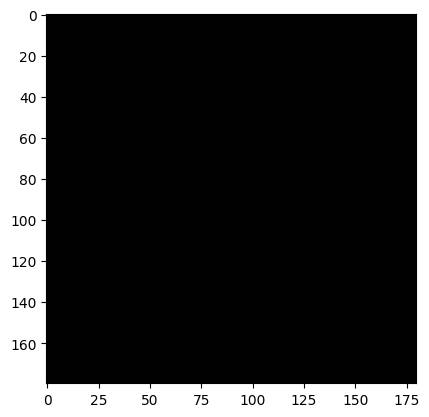

mean fitness after  100  generations:  -5369.1996392413175
best fitness:  -4444.44216839677
mean fitness after  200  generations:  -5111.669743047543
best fitness:  -4272.748604382929
mean fitness after  300  generations:  -4455.826323849802
best fitness:  -4126.000861207228
mean fitness after  400  generations:  -4499.5375214661
best fitness:  -3919.1044213763935
mean fitness after  500  generations:  -4281.198403498654
best fitness:  -3879.4657747020374
mean fitness after  600  generations:  -4344.202515058311
best fitness:  -3834.616270665129
mean fitness after  700  generations:  -4384.894511726258
best fitness:  -3766.6770011534027
mean fitness after  800  generations:  -4395.780947071638
best fitness:  -3715.361645520954
mean fitness after  900  generations:  -4462.011338587723
best fitness:  -3697.33445597847
mean fitness after  1000  generations:  -3783.751214276559
best fitness:  -3697.33445597847


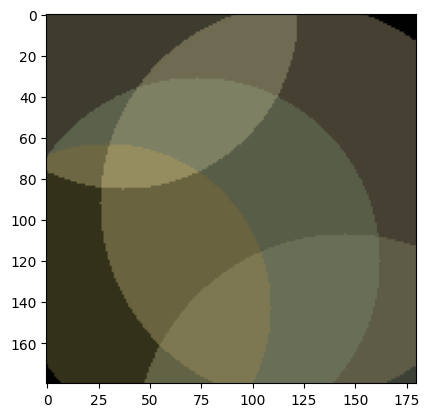

mean fitness after  1100  generations:  -3729.2247882224788
best fitness:  -3440.508988850442
mean fitness after  1200  generations:  -3262.6793726771757
best fitness:  -3061.338608227605
mean fitness after  1300  generations:  -3350.7359624503392
best fitness:  -2989.6428143021913
mean fitness after  1400  generations:  -3209.5690580545956
best fitness:  -2989.6428143021913
mean fitness after  1500  generations:  -3202.258598615916
best fitness:  -2970.2063206459056
mean fitness after  1600  generations:  -3287.3758282071
best fitness:  -2970.2063206459056
mean fitness after  1700  generations:  -3196.058694732796
best fitness:  -2956.3756093810075
mean fitness after  1800  generations:  -3291.9243678713324
best fitness:  -2919.410149942329
mean fitness after  1900  generations:  -3186.99824939126
best fitness:  -2917.065759323337
mean fitness after  2000  generations:  -2904.942614699474
best fitness:  -2873.4633448673585


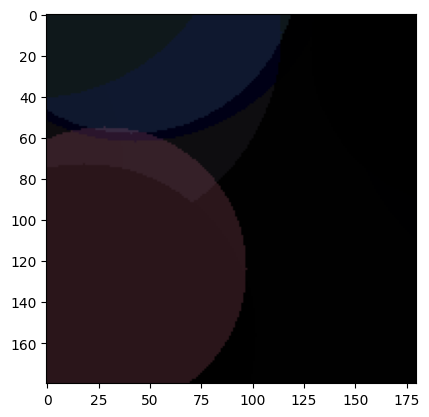

mean fitness after  2100  generations:  -4332.2329664872495
best fitness:  -3599.0001999231063
mean fitness after  2200  generations:  -4014.760781109829
best fitness:  -3365.2892733564004
mean fitness after  2300  generations:  -3748.8572699602714
best fitness:  -3300.8419069588617
mean fitness after  2400  generations:  -3857.01563148789
best fitness:  -3260.291534025375
mean fitness after  2500  generations:  -3927.771858900423
best fitness:  -3159.6025067281817
mean fitness after  2600  generations:  -3511.3283922850187
best fitness:  -3110.923537101115
mean fitness after  2700  generations:  -4198.7352678457
best fitness:  -3079.367012687428
mean fitness after  2800  generations:  -3576.55462194028
best fitness:  -3079.367012687428
mean fitness after  2900  generations:  -3733.501816608997
best fitness:  -3062.5499730872743
mean fitness after  3000  generations:  -2944.366024285531
best fitness:  -2913.259777008843


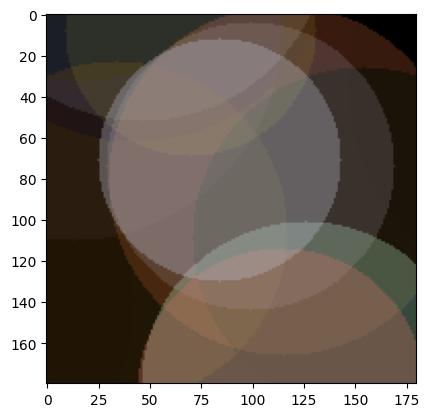

mean fitness after  3100  generations:  -3100.990024990387
best fitness:  -2760.0613917723954
mean fitness after  3200  generations:  -2790.138126041266
best fitness:  -2638.004828911957
mean fitness after  3300  generations:  -3167.9736338587722
best fitness:  -2598.6884121491735
mean fitness after  3400  generations:  -2798.8763389081123
best fitness:  -2569.313756247597
mean fitness after  3500  generations:  -3004.8308416634627
best fitness:  -2556.325582468281
mean fitness after  3600  generations:  -3113.033487120339
best fitness:  -2526.334409842368
mean fitness after  3700  generations:  -2953.5053678072527
best fitness:  -2526.334409842368
mean fitness after  3800  generations:  -2817.5531106625663
best fitness:  -2519.816578239139
mean fitness after  3900  generations:  -2976.838210944509
best fitness:  -2519.816578239139
mean fitness after  4000  generations:  -2541.544998077662
best fitness:  -2519.816578239139


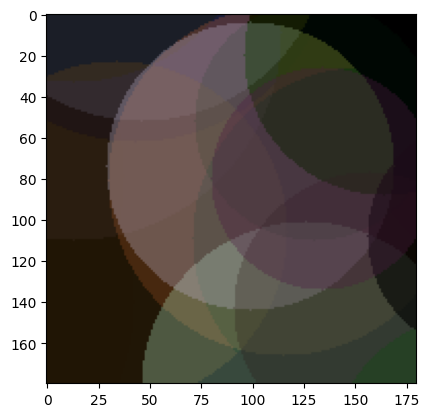

mean fitness after  4100  generations:  -2881.7861463539666
best fitness:  -2577.4745251826225
mean fitness after  4200  generations:  -2852.646169742406
best fitness:  -2483.7771626297576
mean fitness after  4300  generations:  -2747.766319364347
best fitness:  -2453.9386851211075
mean fitness after  4400  generations:  -2635.4573965141612
best fitness:  -2402.3359169550176
mean fitness after  4500  generations:  -2708.2838241701907
best fitness:  -2378.5735332564395
mean fitness after  4600  generations:  -2711.0985822760476
best fitness:  -2364.5713648596693
mean fitness after  4700  generations:  -2670.1624788542867
best fitness:  -2358.8600845828523
mean fitness after  4800  generations:  -2722.734911892862
best fitness:  -2358.8600845828523
mean fitness after  4900  generations:  -2560.4856529539916
best fitness:  -2351.368027681661
mean fitness after  5000  generations:  -2389.5231757016536
best fitness:  -2351.368027681661


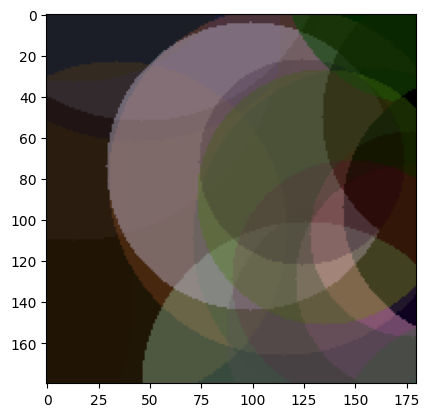

mean fitness after  5100  generations:  -2422.942859156734
best fitness:  -2309.532549019608
mean fitness after  5200  generations:  -2352.9011011790335
best fitness:  -2268.4294348327567
mean fitness after  5300  generations:  -2327.6567502883504
best fitness:  -2254.429880815071
mean fitness after  5400  generations:  -2393.7664834038187
best fitness:  -2212.721614763552
mean fitness after  5500  generations:  -2356.4387895681148
best fitness:  -2212.721614763552
mean fitness after  5600  generations:  -2315.345681468667
best fitness:  -2204.02491349481
mean fitness after  5700  generations:  -2331.374024413687
best fitness:  -2204.02491349481
mean fitness after  5800  generations:  -2322.0338135973343
best fitness:  -2204.02491349481
mean fitness after  5900  generations:  -2380.231795142894
best fitness:  -2204.02491349481
mean fitness after  6000  generations:  -2226.4167307445864
best fitness:  -2204.02491349481


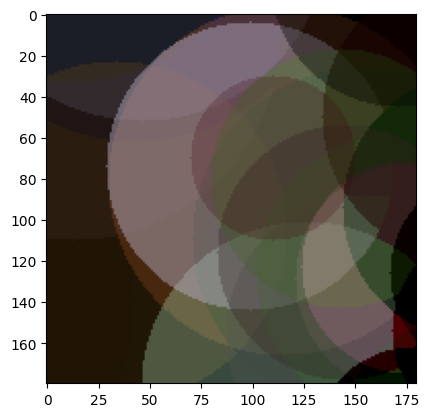

mean fitness after  6100  generations:  -2297.336254966039
best fitness:  -2182.961937716263
mean fitness after  6200  generations:  -2244.8532465077533
best fitness:  -2149.9626143790847
mean fitness after  6300  generations:  -2250.5936620530574
best fitness:  -2127.9060515186466
mean fitness after  6400  generations:  -2221.1481484685382
best fitness:  -2124.945205690119
mean fitness after  6500  generations:  -2193.744509163141
best fitness:  -2106.8091810841984
mean fitness after  6600  generations:  -2181.751460976548
best fitness:  -2106.375809304114
mean fitness after  6700  generations:  -2218.86157791875
best fitness:  -2095.9164167627837
mean fitness after  6800  generations:  -2185.8951159810326
best fitness:  -2085.808535178777
mean fitness after  6900  generations:  -2193.3116429578367
best fitness:  -2085.808535178777
mean fitness after  7000  generations:  -2097.859602716902
best fitness:  -2069.5613687043447


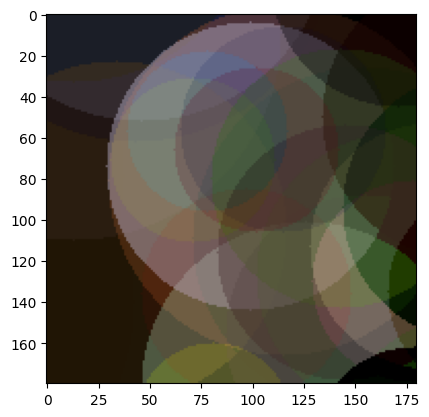

mean fitness after  7100  generations:  -2280.448254197104
best fitness:  -2081.4456747404843
mean fitness after  7200  generations:  -2123.3478075740104
best fitness:  -2032.9769934640524
mean fitness after  7300  generations:  -2207.222242727156
best fitness:  -2032.9765321030372
mean fitness after  7400  generations:  -2117.1475096116874
best fitness:  -2020.8075048058438
mean fitness after  7500  generations:  -2125.0514532871975
best fitness:  -1989.4125336409074
mean fitness after  7600  generations:  -2166.330644303473
best fitness:  -1973.2453671664744
mean fitness after  7700  generations:  -2053.6761043829297
best fitness:  -1963.9418069973085
mean fitness after  7800  generations:  -2047.655495322313
best fitness:  -1963.9418069973085
mean fitness after  7900  generations:  -2081.1181074586693
best fitness:  -1963.9418069973085
mean fitness after  8000  generations:  -1987.209617454827
best fitness:  -1959.2975932333716


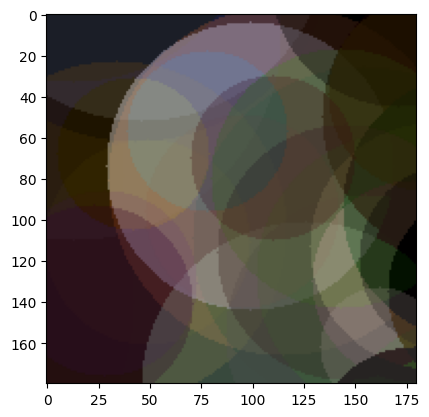

mean fitness after  8100  generations:  -2068.329892989875
best fitness:  -1979.9070972702805
mean fitness after  8200  generations:  -2064.1524990388302
best fitness:  -1977.504590542099
mean fitness after  8300  generations:  -2051.9798939510447
best fitness:  -1975.3150941945405
mean fitness after  8400  generations:  -2014.4625756119437
best fitness:  -1961.0646981930026
mean fitness after  8500  generations:  -1998.5984704600799
best fitness:  -1938.1132795078815
mean fitness after  8600  generations:  -2013.6216512879662
best fitness:  -1938.1132795078815
mean fitness after  8700  generations:  -2009.5747629117002
best fitness:  -1930.6081199538637
mean fitness after  8800  generations:  -2020.3154966038694
best fitness:  -1930.6081199538637
mean fitness after  8900  generations:  -2004.2797228630013
best fitness:  -1930.6081199538637
mean fitness after  9000  generations:  -1951.1630805459424
best fitness:  -1930.6081199538637


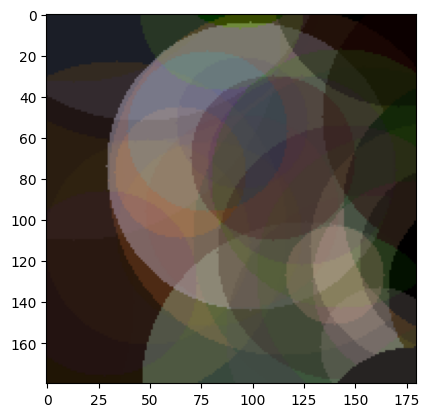

mean fitness after  9100  generations:  -1966.2615907343327
best fitness:  -1898.3335024990388
mean fitness after  9200  generations:  -1971.9310720235808
best fitness:  -1898.3335024990388
mean fitness after  9300  generations:  -1935.2692374727674
best fitness:  -1872.2732948865819
mean fitness after  9400  generations:  -1925.6933352556707
best fitness:  -1872.2732948865819
mean fitness after  9500  generations:  -1977.1753777393312
best fitness:  -1872.2732948865819
mean fitness after  9600  generations:  -1970.4066227732928
best fitness:  -1872.2732948865819
mean fitness after  9700  generations:  -1957.6873583878003
best fitness:  -1870.4081507112649
mean fitness after  9800  generations:  -1907.2473827374095
best fitness:  -1870.4081507112649
mean fitness after  9900  generations:  -1950.6212184416254
best fitness:  -1864.481722414456


 LAST IMAGE 




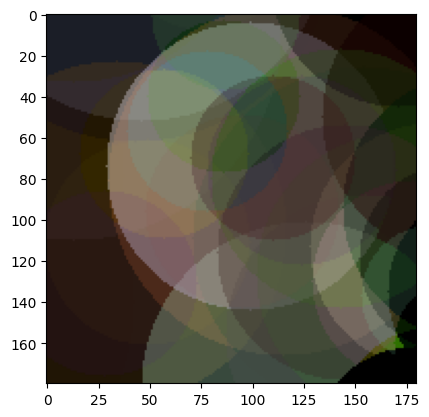

In [ ]:
print("before: ", mean_fitness(popul.individuals))
for i in range(10000):

  popul.selection()
  popul.crossover()
  popul.mutation(1, i)
  popul.new_gen_reset()
  #popul.evaluate_population(img)
  if i % 1000 == 0:
    pass
  else:
    evaluate_group_fitness(popul.individuals, img, last_image, i)

  if i % 100 == 0:
    print("mean fitness after ",i," generations: ", mean_fitness(popul.individuals))
    sorted(popul.individuals, key=lambda x: x.fitness, reverse=True)
    print("best fitness: ", popul.individuals[0].fitness)
    if i % 1000 == 0:
      last_image = draw_individual(popul.individuals[0], len(popul.individuals[0].chromosome), i)
      plt.imshow(last_image)
      plt.show()
    fitness_1_10000.append(popul.individuals[0].fitness)

print("\n\n LAST IMAGE \n\n")
last_image = draw_individual(popul.individuals[0], len(popul.individuals[0].chromosome), i)
plt.imshow(last_image)
plt.show()


### plots

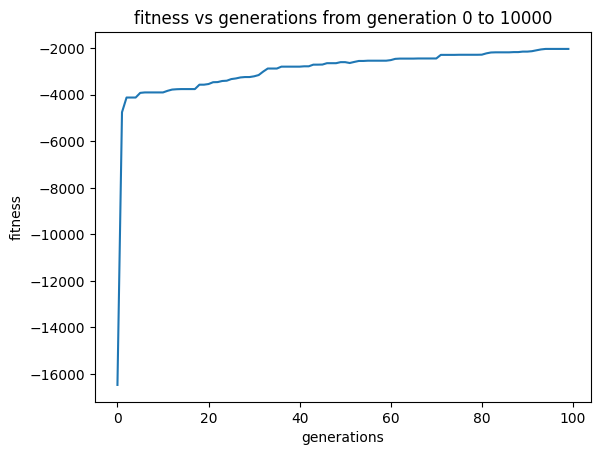

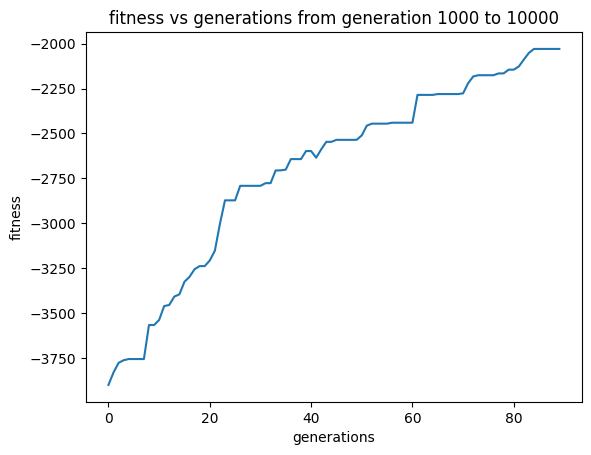

In [ ]:
plt.plot(fitness_1_10000)
plt.xlabel("generations")
plt.ylabel("fitness")
plt.title("fitness vs generations from generation 0 to 10000")
plt.show()

plt.plot(fitness_1_10000[10:])
plt.xlabel("generations")
plt.ylabel("fitness")
plt.title("fitness vs generations from generation 1000 to 10000")
plt.show()

### Area 51

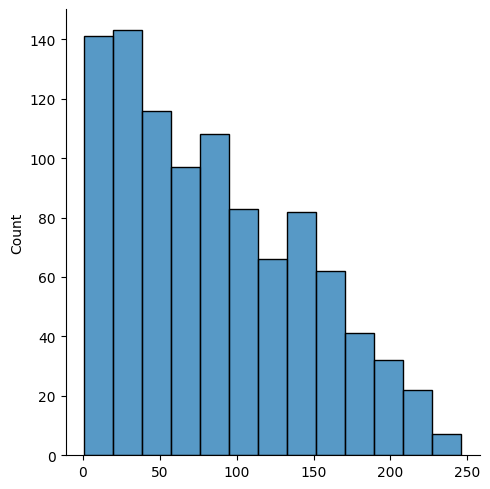

In [ ]:
import seaborn as sns

low = 1
high = 255
numbers = []

prob_distribution = np.arange(high, low - 1, -1)
prob_distribution = prob_distribution / np.sum(prob_distribution)


for i in range(1000):
  random_integer = np.random.choice(np.arange(low, high+1), p=prob_distribution)
  numbers.append(random_integer)

sns.displot(numbers)


openCV playgorund

<function matplotlib.pyplot.show(close=None, block=None)>

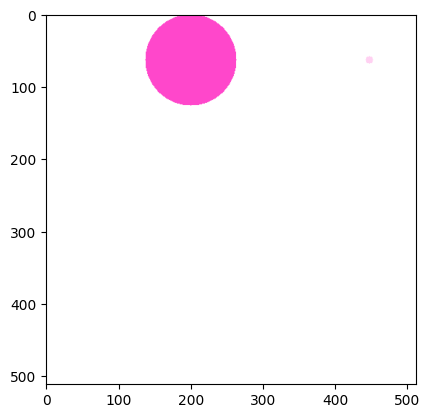

In [ ]:
import matplotlib.pyplot as plt

# Create a canvas rightmost number is its
img = np.ones((512,512,3), np.uint8) * 255
img2 = np.ones((512,512,3), np.uint8) * 255

alpha = 0.2

# Circle(canvas, center coordinates, radius, (R, G, B), contour width)
cv2.circle(img,(447,63), 5, (190,25,255), -1)
cv2.circle(img2,(200,63), 63, (190,25,255), -1)

image = cv2.addWeighted(img, alpha, img2, 1 - alpha, 0)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show

In [ ]:
def copy_individual(individual, chromosome_length):
  new_individual = Individual([])
  for i in range(chromosome_length):
    new_individual.chromosome.append([])
    for j in range(3):
      new_individual.chromosome[i].append(individual.chromosome[i][j])
  return new_individual


A = [[1,2,3], [4,5,6], [7,8,9]]
I1 = Individual(A)

I2 = copy_individual(I1, 3)

I2.chromosome[0][0] = 100

print(I1.chromosome)
print(I2.chromosome)

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[100, 2, 3], [4, 5, 6], [7, 8, 9]]


In [ ]:
for i in range(10):
  print(i)

0
1
2
3
4
5
6
7
8
9
